# Import

In [1]:
import numpy as np                           
from mindquantum.core.gates import X, Y, Z, I, H, Rzz, RZ, RY, RX, Rxx, Ryy   
from mindquantum.simulator import Simulator  
from mindquantum.core.circuit import Circuit 
from mindquantum.core.parameterresolver import ParameterResolver
from mindquantum.core.gates import Measure  
from mindquantum.core.operators import QubitOperator, Hamiltonian, commutator
import networkx as nx
import re
import copy
import matplotlib.pyplot as plt
from openqaoa.utilities import ground_state_hamiltonian
from openqaoa.problems import MaximumCut
from openqaoa.utilities import plot_graph

# QAOA cost Hamilton, Mixer Functions

### Rzy Gate

In [2]:
from mindquantum.core.gates import gene_univ_parameterized_gate
import numba
'''
   定义 Rzy 门，Rzy(θ) = exp(-i θ/2 (Y⊗Z) )
   .on([a,b])
   当 a>b, 作用 exp(-i θ/2 (Y⊗Z) )
   当 a<b, 作用 exp(-i θ/2 (Z⊗Y) )
'''
def matrix(alpha):
    ep = np.cos(alpha/2)
    em = np.sin(alpha/2)
    return np.array([
        [ep + 0.0j, 0.0j, -em + 0.0j, 0.0j],
        [0.0j, ep + 0.0j, 0.0j, em + 0.0j],
        [em + 0.0j, 0.0j, ep + 0.0j, 0.0j],
        [0.0j, -em + 0.0j, 0.0j, ep + 0.0j]
    ])
def diff_matrix(alpha):
    ep = -0.5 * np.sin(alpha/2)
    em = 0.5 * np.cos(alpha/2)
    return np.array([
        [ep + 0.0j, 0.0j, -em + 0.0j, 0.0j],
        [0.0j, ep + 0.0j, 0.0j, em + 0.0j],
        [em + 0.0j, 0.0j, ep + 0.0j, 0.0j],
        [0.0j, -em + 0.0j, 0.0j, ep + 0.0j]
    ])
Rzy = gene_univ_parameterized_gate('Rzy', matrix, diff_matrix)

### qaoa_hamil: add a layer of Rzz

In [3]:
'''
   对当前线路 circ 加上一层 Rzz 门
'''
def qaoa_hamil(circ, qubo, gamma):
    ising = qubo.terms
    weight = qubo.weights
    
    if isinstance(gamma, str):
        for index, term in enumerate(ising):
            pr = ParameterResolver({gamma : weight[index]})
            circ += Rzz(pr).on([term[0], term[1]])
            
    if isinstance(gamma, (int, float)):
        for index, term in enumerate(ising):
            circ += Rzz(gamma*weight[index]).on([term[0], term[1]])

    circ.barrier()

### qaoa_mixer:add a layer of mixer

In [4]:
'''
   根据 mixer，对当前线路 circ 加上一层对应的 U
'''
def qaoa_mixer(circ, mixer_str, beta, qubits):

    letters = re.findall(r'[A-Z]', mixer_str)
    numbers = re.findall(r'\d+', mixer_str)
    letters_str = ''.join(letters)
    nums = [int(num) for num in numbers]
    
    pr = ParameterResolver({beta : 2})
    
    if letters_str == 'XX':
        circ += Rxx(pr).on(nums)
    if letters_str == 'YY':
        circ += Ryy(pr).on(nums)
    if letters_str == 'YZ':
        circ += Rzy(pr).on([max(nums),min(nums)])
    if letters_str == 'ZY':
        circ += Rzy(pr).on([min(nums),max(nums)])
    if letters_str == 'X'*qubits:
        for i in range(qubits):
            circ += RX(pr).on(i)
    if letters_str == 'Y'*qubits:
        for i in range(qubits):
            circ += RY(pr).on(i)
    if letters_str == 'X':
        circ += RX(pr).on(nums)
    if letters_str == 'Y':
        circ += RY(pr).on(nums) 
    circ.barrier()

# Pool func:Creating Operator String Pool

In [5]:
'''
   单比特的 mixer：1.{Xj, Yj}(j=1,...,N)
   全比特的 mixer：2.{∑Xi, ∑Yi}
'''
def mixer_pool_single(qubits):

    pool = []
    
    single_X = [f'X{i}' for i in range(qubits)]
    pool.extend(single_X)
    
    all_X = ' '.join([f'X{i}' for i in range(qubits)])
    pool.extend([all_X])   
    
    single_Y = [f'Y{i}' for i in range(qubits)]
    pool.extend(single_Y)
    
    all_Y = ' '.join([f'Y{i}' for i in range(qubits)])
    pool.extend([all_Y])        

    return pool

In [6]:
'''
   双比特的 mixer：{XX, YY, YZ, ZY}
'''
def mixer_pool_multi(qubits):
    number_pairs = []
    for i in range(qubits):
        for j in range(i + 1, qubits):
            number_pairs.append(f'{i}{j}')

    letter_pairs = ['Y Z','Z Y','X X','Y Y']

    pool = []
    for num in number_pairs:
        for let in letter_pairs:
            pool.append(f'{let[0]}{num[0]} {let[2]}{num[1]}')
    return pool

# Evaluating derivative:

In [7]:
'''
   得到问题的哈密顿量，Hc = 1/2 ∑(wZZ)
'''
def hamilC(qubo):
    def hamil_str(pos):
        result = f'Z{pos[0]} Z{pos[1]}'
        return result

    hamil_op = QubitOperator()
    for index,term in enumerate(qubo.terms):
        hamil_op += QubitOperator(hamil_str(term), qubo.weights[index]/2)
    
    return hamil_op

In [8]:
'''
   求 [Hc,Ac] 对当前线路的期望值 -i <ψ| [Hc,Ac] |ψ>
'''
def derivative(qubo, qubits, mixer, circ):
    commu = (-1j) * commutator(hamilC(qubo), QubitOperator(mixer))
    ham = Hamiltonian(commu)
    
    sim = Simulator("mqvector", qubits)
    expectation = sim.get_expectation(ham, circ)
    return expectation.real

# Optimization:using scipy

In [9]:
from scipy.optimize import minimize
'''
   传统 minimize COBYLA 方法优化搜索，返回收敛值和参数值
   每层优化前的初始值 为 上一层的优化参数 和 这一层的[0.01,0]
'''
def opt(qubo, circ, qubits, theta, method):
    ham = Hamiltonian(hamilC(qubo))
    sim = Simulator('mqvector', qubits)
    grad_ops = sim.get_expectation_with_grad(ham, circ)
       
    if len(theta)<2:
        p0 = np.array([0.01,0.0])
    else:
        p = np.array(list(theta.values()))
        p0 = np.append(p,[0.01,0.0]) 
   
    def fun(p, grad_ops):
        f, g = grad_ops(p)
        f = np.real(f)[0,0]
        g = np.real(g)[0,0]
        return f
    
    res = minimize(fun, p0, args=(grad_ops, ), method=method) 
    
    return dict(zip(circ.params_name, res.x)), res.fun

# Method 1: Adapt QAOA Algorithm

In [10]:
def ADAPT_QAOA(nodes, qubo, pool, layers,method):

    circ = Circuit()
    for qubit in range(nodes):
        circ += H.on(qubit)
    circ.barrier()

    k = 0 
    theta = {}
    mixers_used = []
    allthemin = []
    
    while True:
        gradients = []
        circ_grad = copy.deepcopy(circ.apply_value(theta))
        
        qaoa_hamil(circ_grad, qubo, 0.01)
               
        for mixer in pool:
            gradients.append(abs(derivative(qubo, nodes, mixer, circ_grad))) 
        mixers_used.append(pool[np.argmax(gradients)]) 
        
        if k == layers: 
            return theta, allthemin, circ        
        k += 1
  
        qaoa_hamil(circ, qubo, f'g{k}')
        qaoa_mixer(circ, mixers_used[-1], f'b{k}', nodes)
        
        result, qubo_min = opt(qubo, circ, nodes, theta, method)
        theta = result
        allthemin.append(qubo_min)
        print(k, mixers_used[-1], allthemin[-1])

# Method 2: standard QAOA(the same iterative strategy)

In [11]:
def QAOA(qubo, nodes, layers, method):
    weight = qubo.weights
    circ = Circuit()
    for qubit in range(nodes):
        circ += H.on(qubit)
    circ.barrier()

    def build_hc(circ, g):
        for index,value in enumerate(qubo.terms):
            pr = ParameterResolver({g:weight[index]})
            circ += Rzz(pr).on(value)
        circ.barrier()
    def build_hb(circ, b):
        for i in range(nodes):
            pr = ParameterResolver({b:2})
            circ += RX(pr).on(i)
        circ.barrier()
    
    allthemin = []
    k=0
    theta = {}
    while True:
        if k == layers:
            return theta, allthemin, circ
        k += 1
        
        build_hc(circ,f'g{k}')
        build_hb(circ,f'b{k}')
        result, qubo_min = opt(qubo, circ, nodes, theta, method)
        theta = result
        allthemin.append(qubo_min)
        print(k, allthemin[-1])

#  Maxcut Instance Function

In [12]:
'''
   两种图：complete、regular
   四种权值分布：uniform、exponential、normal、uniform2
   图的绘制
'''
def graph_complete(nodes, distribution):
    G = nx.complete_graph(nodes)
    
    if distribution == 'uniform':
        for (u, v) in G.edges():
            G.edges[u,v]['weight'] = np.random.uniform(0, 1)
    if distribution == 'exponential':
        for (u, v) in G.edges():
            G.edges[u,v]['weight'] = np.random.exponential(1)
    if distribution == 'normal':
        for (u, v) in G.edges():
            G.edges[u,v]['weight'] = np.random.normal(0, 1)
    if distribution == 'uniform2':
        for (u, v) in G.edges():
            G.edges[u,v]['weight'] = np.random.uniform(-1, 1)
    return MaximumCut(G).qubo

def draw_graph(qubo):
    G = nx.Graph()
    for edge, weight in zip(qubo.terms, qubo.weights):
        G.add_edge(edge[0], edge[1], weight=weight)
    plot_graph(G)

# Set Problem

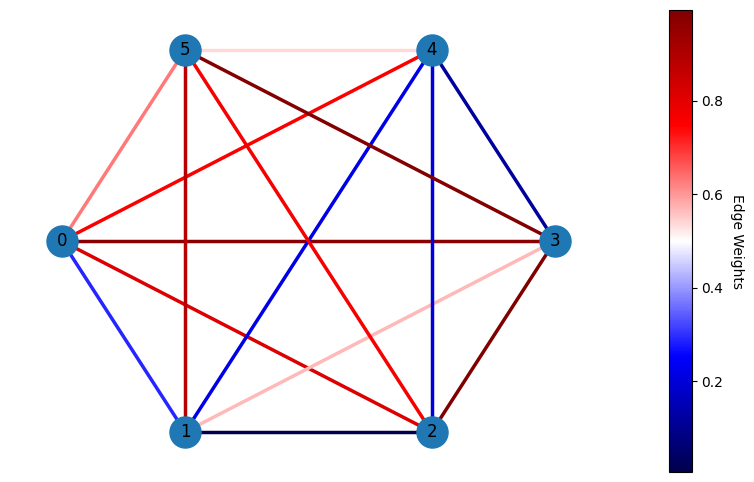

In [26]:
nodes = 6
qubo = graph_complete(nodes,'uniform')
draw_graph(qubo)

In [27]:
%%time
pr_qaoa, value_qaoa, circ_qaoa = QAOA(qubo, nodes, 10,'bfgs')

1 -0.8646903929865247
2 -1.114287927953509
3 -1.2754692707987227
4 -1.378974990756344
5 -1.4482755306071313
6 -1.5034344582961783
7 -1.540983932585379
8 -1.5729465731642136
9 -1.5734133838860396
10 -1.595261446100825
CPU times: total: 12.5 s
Wall time: 12.5 s


In [28]:
%%time
pool = mixer_pool_single(nodes) + mixer_pool_multi(nodes)
pr_adapt_qaoa, value_adapt_qaoa, circ_adapt = ADAPT_QAOA(nodes, qubo, pool, 10,'bfgs')

1 Y2 Z3 -0.49719359674107766
2 Y1 Z5 -0.939554589273821
3 Z0 Y4 -1.3166407800976072
4 Y2 Y3 -1.47023258323764
5 Y3 Z5 -1.517822295082618
6 Y2 Z3 -1.598782451025789
7 Z2 Y3 -1.617726886788217
8 Z1 Y2 -1.619794046046913
9 Y2 Y3 -1.6252881121377145
10 X2 X4 -1.6252881133096
CPU times: total: 11.5 s
Wall time: 11.6 s


In [29]:
energy, configuration = ground_state_hamiltonian(qubo.hamiltonian)
print(f"Ground State energy: {energy/2}, Gonfiguration: {configuration}")

Ground State energy: -1.631634435169901, Gonfiguration: ['011110', '100001']
